# Q2 - Experiments Python CRF suite

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import cPickle as pickle
import pycrfsuite
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from pycrfsuite import Tagger
from flexcrf_tp.models.linear_chain import (_feat_fun_values,
                                            _compute_all_potentials,
                                            _forward_score,
                                            _backward_score,
                                            _partition_fun_value,
                                            _posterior_score)

from flexcrf_tp.crfsuite2flexcrf import convert_data_to_flexcrf

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

In [136]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

In [137]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 3.75 s, sys: 476 ms, total: 4.22 s
Wall time: 4.26 s


In [138]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

CPU times: user 5.92 s, sys: 713 ms, total: 6.64 s
Wall time: 6.76 s


In [139]:
trainer.set_params({
    'c1': 1e-2,   # coefficient for L1 penalty
    'c2': 1e-1,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [140]:
trainer.train('conll2002/conll2002-esp.crfsuite')

In [141]:
def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return precision_score(y_true_combined, 
                    y_pred_combined, 
                    labels = [class_indices[cls] for cls in tagset], 
                    average="weighted"),\
           recall_score(y_true_combined, 
                    y_pred_combined, 
                    labels = [class_indices[cls] for cls in tagset], 
                    average="weighted"),\
           f1_score(y_true_combined, 
                    y_pred_combined, 
                    labels = [class_indices[cls] for cls in tagset], 
                    average="weighted"),\
           classification_report(
                     y_true_combined,
                     y_pred_combined,
                     labels = [class_indices[cls] for cls in tagset],
                     target_names = tagset,
        )

In [142]:
%%time
tagger = pycrfsuite.Tagger()
tagger.open('conll2002/conll2002-esp.crfsuite')

CPU times: user 1.64 ms, sys: 5.29 ms, total: 6.93 ms
Wall time: 73.9 ms


In [143]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [144]:
print(bio_classification_report(y_test, y_pred)[3])

             precision    recall  f1-score   support

      B-LOC       0.80      0.78      0.79      1084
      I-LOC       0.69      0.62      0.65       325
     B-MISC       0.73      0.55      0.63       339
     I-MISC       0.72      0.57      0.63       557
      B-ORG       0.81      0.84      0.82      1400
      I-ORG       0.85      0.80      0.82      1104
      B-PER       0.85      0.88      0.86       735
      I-PER       0.89      0.94      0.91       634

avg / total       0.81      0.78      0.79      6178



### Tests avec différents paramètres de régularisation C1 et C2

In [35]:
# Définition des grid search
grid_c1 = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
grid_c2 = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

# Définition de la matrice dans laquelle nous allons
# stocker les résultats
result = np.ones((len(grid_c1) * len(grid_c2), 5))
i = 0

for c1 in grid_c1:
    for c2 in grid_c2:
        
        # Définition des paramètres du modèle
        trainer.set_params({
            'c1': c1,
            'c2': c2,
            'max_iterations': 50,
            'feature.possible_transitions': True
        })
        
        # Entrainement du modèle
        trainer.train('conll2002/conll2002-esp.crfsuite')
       
        # Prédiction sur les données de test
        tagger = pycrfsuite.Tagger()
        tagger.open('conll2002/conll2002-esp.crfsuite')
        y_pred= ""
        y_pred = [tagger.tag(xseq) for xseq in X_test]
        
        # Stockage des résultats
        result[i, 0] = c1
        result[i, 1] = c2
        precision, recall, f1, report = bio_classification_report(y_test, y_pred)
        result[i, 2] = precision
        result[i, 3] = recall
        result[i, 4] = f1
        i += 1

In [78]:
# Défition de la fonction d'affichage des résultats
def plot_result(x_range, precision, recall, f1, title, xlabel): 
    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.semilogx(x_range, f1, 'r', label="f1")
    plt.semilogx(x_range, precision, 'b', label="precision")
    plt.semilogx(x_range, recall, 'g', label="recall")

    plt.legend(loc="lower left")
    plt.show()

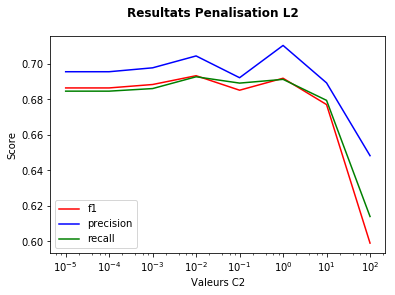

In [82]:
# Cas c1 = 0 (pas de régularisation L1)
# Récupération des résultats pour ce cas
x_range = result[np.where(result[:, 0] == 0), 1][0]
precision = result[np.where(result[:, 0] == 0), 2][0]
recall = result[np.where(result[:, 0] == 0), 3][0]
f1 = result[np.where(result[:, 0] == 0), 4][0]

# Affichage des résultats
plot_result(x_range, precision, recall, f1, "Resultats Penalisation L2", "Valeurs C2")

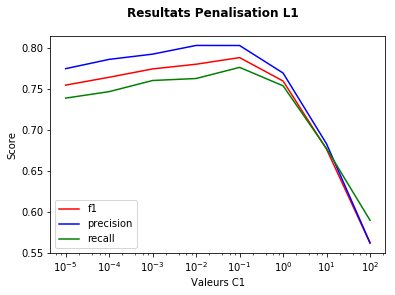

In [86]:
# Cas c2 = 0 (pas de régularisation L2)
# Récupération des résultats pour ce cas
x_range = result[np.where(result[:, 1] == 0), 0][0]
precision = result[np.where(result[:, 1] == 0), 2][0]
recall = result[np.where(result[:, 1] == 0), 3][0]
f1 = result[np.where(result[:, 1] == 0), 4][0]

# Affichage des résultats
plot_result(x_range, precision, recall, f1, "Resultats Penalisation L1", "Valeurs C1")

In [105]:
print("Résultat sans pénalisation : precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}\n")\
    .format(result[0, 2], result[0, 3], result[0, 4])

index_best_score = np.argmax(result[:, 4])

print("Meilleur F1 score : precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}\n")\
    .format(result[index_best_score, 2], result[index_best_score, 3], result[index_best_score, 4])

print("Le meilleur score est obtenu pour le paramétrage suivant : c1 = {} et c2 = {}"\
    .format(result[index_best_score, 0], result[index_best_score, 1]))

Résultat sans pénalisation : precision = 0.695, recall = 0.685, f1 = 0.686

Meilleur F1 score : precision = 0.806, recall = 0.782, f1 = 0.793

Le meilleur score est obtenu pour le paramétrage suivant : c1 = 0.01 et c2 = 0.1



### Résultats

La régularisation L1 permet de bien améliorer le score alors que la régularisation L2 n'a pas beaucoup d'impact sur le score.

La norme 1 permet de choisir certaines composantes, et fonctionne correctement dans ce cas entre autre parce que la matrice de features est sparce.

La norme 2 permet de conserver des paramètres du modèle pas trop élevés.

# Q3 - Coding your own CRF inference routines in python

In [145]:
CRFSUITE_MODEL_FILE = 'conll2002/conll2002-esp.crfsuite'
CRFSUITE_TEST_DATA_FILE = 'conll2002/conll2002-esp_crfsuite-test-data.dump'
FLEXCRF_TEST_DATA_FILE = 'conll2002/conll2002-esp_flexcrf-test-data.dump'

In [146]:
# crfsuite model
tagger = Tagger()
tagger.open(CRFSUITE_MODEL_FILE)
model = tagger.info()

data = pickle.load(open(CRFSUITE_TEST_DATA_FILE, 'rb'))
print("test data loaded.")

test data loaded.


In [147]:
RECREATE = True  # set to True to recreate flexcrf data with new model

if RECREATE:
    dataset, thetas = convert_data_to_flexcrf(data, model, n_seq=3)
    pickle.dump({'dataset': dataset, 'thetas': thetas},
                open(FLEXCRF_TEST_DATA_FILE, 'wb'), protocol=2)
else:
    dd = pickle.load(open(FLEXCRF_TEST_DATA_FILE, 'rb'))
    dataset = dd['dataset']
    thetas = dd['thetas']


converting to flexcrf format...
f_xy_desc created.
t_xyy_desc created
Processing sentence 1/3...
Processing sentence 2/3...
Processing sentence 3/3...


### Implémentation du décodeur Viterbi

In [148]:
def viterbi_decoder(m_xy, n=None, log_version=True):
    """
    Performs MAP inference, determining $y = \argmax_y P(y|x)$, using the
    Viterbi algorithm.

    Parameters
    ----------
    m_xy : ndarray, shape (n_obs, n_labels, n_labels)
        Values of log-potentials ($\log M_i(y_{i-1}, y_i, x)$)
        computed based on feature functions f_xy and/or user-defined potentials
        `psi_xy`. At t=0, m_xy[0, 0, :] contains values of $\log M_1(y_0, y_1)$
        with $y_0$ the fixed initial state.

    n : integer, default=None
        Time position up to which to decode the optimal sequence; if not
        specified (default) the score is computed for the whole sequence.

    Returns
    -------
    y_pred : ndarray, shape (n_obs,)
        Predicted optimal sequence of labels.

    """

    # Intialisation des variables
    nb_words = m_xy.shape[0]
    nb_states = m_xy.shape[1]

    delta = np.zeros((nb_words, nb_states))
    psi = np.zeros((nb_words, nb_states))
    delta[0, :] = m_xy[0, 0, :]
    psi[0, :] = 0
    y_pred = np.zeros(nb_words)

    # Récurrence pour calculer delta et psi
    for w in range(1, nb_words):
        for s in range(nb_states):
            delta[w, s] = np.max(delta[w - 1, :] + m_xy[w, :, s])
            psi[w, s] = np.argmax(delta[w - 1, :] + m_xy[w, :, s])

    # Calcul par backtracking d'y_pred
    y_pred[nb_words - 1] = int(np.argmax(delta[nb_words - 1, :]))

    for w in range(nb_words - 2, -1, -1):
        y_pred[w] = int(psi[w + 1, int(y_pred[w + 1])])

    return y_pred

### Calcul de la probabilité à postériori de la séquence trouvée

In [149]:
for seq in range(len(dataset)):
    # -- with crfsuite
    s_ = tagger.tag(data['X'][seq])
    y_ = np.array([int(model.labels[s]) for s in s_])
    prob_ = tagger.probability(s_)

    print("\n-- With crfsuite:")
    print("labels:\n", s_, "\n", y_)
    print("probability:\t %f" % prob_)

    # -- with flexcrf
    f_xy, y = dataset[seq]
    theta = thetas[seq]
    m_xy, f_m_xy = _compute_all_potentials(f_xy, theta)

    y_pred = viterbi_decoder(m_xy)
    alpha = _forward_score(m_xy)
    beta = _backward_score(m_xy)
    z_x = _partition_fun_value(alpha)
    f_x = _feat_fun_values(f_xy, y_pred, with_f_x_sum=False)
    prob = np.exp(_posterior_score(f_x, theta, z_x=z_x))

    print("-- With flexcrf:")
    print("labels:\n", y_pred)
    print("equal predictions: ", all(y_pred == y_))
    print("probability:\t %f" % prob)
    print("delta:\t %f" % abs(prob-prob_))
tagger.close()


-- With crfsuite:
('labels:\n', ['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'], '\n', array([0, 7, 1, 1, 1, 1, 2, 1, 1]))
probability:	 0.984796
-- With flexcrf:
('labels:\n', array([ 0.,  7.,  1.,  1.,  1.,  1.,  2.,  1.,  1.]))
('equal predictions: ', True)
probability:	 0.984796
delta:	 0.000000

-- With crfsuite:
('labels:\n', ['O'], '\n', array([1]))
probability:	 0.999999
-- With flexcrf:
('labels:\n', array([ 1.]))
('equal predictions: ', True)
probability:	 0.999999
delta:	 0.000000

-- With crfsuite:
('labels:\n', ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O'], '\n', array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 4, 1, 1, 1, 1, 1, 0,
       7, 1]))
probability:	 0

# Q4 - Going further

### Avant d'implementer de nouvelles features, voyons le résultats sur le jeu de données conll2000 avec le code précédent

In [112]:
train_sents = list(nltk.corpus.conll2000.iob_sents('train.txt'))
test_sents = list(nltk.corpus.conll2000.iob_sents('test.txt'))

In [113]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 4.07 s, sys: 2.12 s, total: 6.19 s
Wall time: 8.65 s


In [114]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

CPU times: user 4.56 s, sys: 401 ms, total: 4.96 s
Wall time: 5.22 s


In [115]:
trainer.set_params({
    'c1': 1e-2,   # coefficient for L1 penalty
    'c2': 1e-1,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [116]:
trainer.train('conll2002/conll2000.crfsuite')

In [117]:
%%time
tagger = pycrfsuite.Tagger()
tagger.open('conll2002/conll2000.crfsuite')

CPU times: user 1.87 ms, sys: 8.87 ms, total: 10.7 ms
Wall time: 51.4 ms


In [118]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [119]:
print(bio_classification_report(y_test, y_pred)[3])

             precision    recall  f1-score   support

     B-ADJP       0.80      0.75      0.78       438
     I-ADJP       0.82      0.66      0.73       167
     B-ADVP       0.84      0.81      0.82       866
     I-ADVP       0.65      0.61      0.63        89
    B-CONJP       0.45      0.56      0.50         9
    I-CONJP       0.62      0.77      0.69        13
     B-INTJ       1.00      1.00      1.00         2
      B-LST       0.00      0.00      0.00         5
      I-LST       0.00      0.00      0.00         2
       B-NP       0.96      0.96      0.96     12422
       I-NP       0.96      0.96      0.96     14376
       B-PP       0.96      0.98      0.97      4811
       I-PP       0.74      0.67      0.70        48
      B-PRT       0.76      0.79      0.77       106
     B-SBAR       0.87      0.82      0.85       535
     I-SBAR       0.18      0.75      0.29         4
       B-VP       0.96      0.95      0.96      4658
       I-VP       0.94      0.96      0.95   

### Nous allons maintenant ajouter de nouvelles features
 - Nous avons rajouté toutes les features décrites sur le site http://www.chokkan.org/software/crfsuite/tutorial.html.
 
 - A savoir, 
     - les mots  m-2 et m+2
     - les postags p-2 et p+2
     - les concaténations de mots avec le mot précédent et avec le mot suivant
     - les concaténations des postags sur 2 et 3 niveaux
 
 - Nous avons aussi ajouté un attribut qui indique si le mot n'est composé que de lettres 

In [132]:
def word2features_with_new_features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    # Features pour le mot en tant que tel
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-5:]=' + word[-5:],
        'word[-4:]=' + word[-4:],
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.isalpha=%s' % word.isalpha(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    
    # Features liées au mot précédent
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.isalpha=%s' % word.isalpha(),
            '-1:word.isdigit=%s' % word.isdigit(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
    
    # Features liées au second mot précédent
    if i > 1:
        word2 = sent[i-2][0]
        postag2 = sent[i-2][1]
        features.extend([
            '-2:word.lower=' + word2.lower(),
            '-2:word.istitle=%s' % word2.istitle(),
            '-2:word.isupper=%s' % word2.isupper(),
            '-2:word.isalpha=%s' % word.isalpha(),
            '-2:word.isdigit=%s' % word.isdigit(),
            '-2:postag=' + postag2,
            '-2:postag[:2]=' + postag2[:2],
        ])
        
    # Features liées au second mot suivant
    if i < len(sent)-2:
        word2 = sent[i+2][0]
        postag2 = sent[i+2][1]
        features.extend([
            '+2:word.lower=' + word2.lower(),
            '+2:word.istitle=%s' % word2.istitle(),
            '+2:word.isupper=%s' % word2.isupper(),
            '+2:word.isalpha=%s' % word.isalpha(),
            '+2:word.isdigit=%s' % word.isdigit(),
            '+2:postag=' + postag2,
            '+2:postag[:2]=' + postag2[:2],
        ])
    
    # Features liées au mot suivant
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.isalpha=%s' % word.isalpha(),
            '+1:word.isdigit=%s' % word.isdigit(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')

    
    # Features qui concatènent plusieurs valeurs
    if i > 0:
        features.extend([
            '-10:word.lower=' + sent[i-1][0] + '|' + sent[i][0],
            '-10:postag=' + sent[i-1][1] + '|' + sent[i][1],

        ])
    
    if i < len(sent)-1:
        features.extend([
            '+10:word.lower=' + sent[i][0] + '|' + sent[i+1][0],
            '+10:postag=' + sent[i][1] + '|' + sent[i+1][1],
        ])
    
    if (i > 0 and i < len(sent)-1):
        features.extend([
            '-101:postag=' + sent[i-1][1] + '|' + sent[i][1] +  '|' + sent[i+1][1],
        ])
    
    if i > 1:
        features.extend([
            '-210:postag=' + sent[i-2][1] + '|' + sent[i-1][1] + '|' + sent[i][1],
        ])
    
    if i < len(sent)-2:
        features.extend([
            '210:postag=' + sent[i][1] + '|' + sent[i+1][1] + '|' + sent[i+2][1],
        ])

    return features


def sent2features_with_new_features(sent):
    return [word2features_with_new_features(sent, i) for i in range(len(sent))]
   

In [124]:
%%time
X_train = [sent2features_with_new_features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features_with_new_features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 10.1 s, sys: 3.12 s, total: 13.2 s
Wall time: 18 s


In [125]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

CPU times: user 24.3 s, sys: 2.87 s, total: 27.2 s
Wall time: 32.4 s


In [126]:
trainer.set_params({
    'c1': 1e-2,   # coefficient for L1 penalty
    'c2': 1e-1,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [127]:
trainer.train('conll2002/conll2000.crfsuite')

In [128]:
tagger = pycrfsuite.Tagger()
tagger.open('conll2002/conll2000.crfsuite')

In [130]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_test]

CPU times: user 2.33 s, sys: 520 ms, total: 2.85 s
Wall time: 3.64 s


In [131]:
print(bio_classification_report(y_test, y_pred)[3])

             precision    recall  f1-score   support

     B-ADJP       0.82      0.77      0.79       438
     I-ADJP       0.82      0.68      0.74       167
     B-ADVP       0.85      0.82      0.83       866
     I-ADVP       0.65      0.57      0.61        89
    B-CONJP       0.56      0.56      0.56         9
    I-CONJP       0.71      0.77      0.74        13
     B-INTJ       1.00      1.00      1.00         2
      B-LST       0.00      0.00      0.00         5
      I-LST       0.00      0.00      0.00         2
       B-NP       0.97      0.97      0.97     12422
       I-NP       0.97      0.97      0.97     14376
       B-PP       0.97      0.98      0.97      4811
       I-PP       0.77      0.71      0.74        48
      B-PRT       0.76      0.76      0.76       106
     B-SBAR       0.88      0.85      0.87       535
     I-SBAR       0.12      0.50      0.19         4
       B-VP       0.96      0.96      0.96      4658
       I-VP       0.95      0.96      0.96   

### Conclusion
Avec ces nouvelles features le score a été très légèrement amélioré : nous sommes passé de 95% à 96% de bons résultats